## Introduction

Your goal is to assess the trade-offs of stability, accuracy, and run-time of a least two methods applied to two ODE systems. 

The first ODE system is two proteins degrading. The ODEs are:

\begin{eqnarray*}
\frac{dy_1}{dt}&=&-\alpha y_1\\
\frac{dy_2}{dt}&=&-\beta y_2\\
\end{eqnarray*}

where $\alpha=0.1$ and $\beta=0.2$.

The second ODE system is the Lotka-Volterra model of predator-prey populations and their interactions. You can check out the Wikipedia entry to learn more, but what you need to know here is that it is a 2-ODE system and that, with the right parameter values, it leads to oscillations. The ODEs are:

\begin{align*}
\frac{dx}{dt} &= \alpha x -\beta x y\\
\frac{dy}{dt} &= -\gamma y + \delta x y\\
\end{align*}

where $\alpha=0.25$, $\beta=0.01$, $\gamma=1$, and $\delta=0.01$.


## The Project

Consider three methods -- the forward Euler method, the explicit trapezoidal method, and an adaptive step-size forward Euler method (that uses the trapezoidal method to estimate the local error).

Compare the performance of each of your three methods on the degradation and predator-prey systems.  In your analysis, you will want to consider both efficiency (how long does it take the method to run?) and accuracy (how close is the method to the "true" solution?). For the first two methods, be sure to consider the effect of step-size on accuracy and speed. For the third, be sure to analyze the step-sizes chosen and the effect of error tolerance on the step size. 


## Extensions

This project will be more interesting if you tackle one or more of these extensions.  Feel free to develop your own extension. And, as always, a particularly thorough analysis is smiled upon.

<ul>
<li> Analyze the van der Pol oscillator in addition to the models above. The equations for it are:
\begin{align*}
\frac{dy_1}{dt} &= y_2\\
\frac{dy_2}{dt} &= \mu (1-y_1^2)y_2 - y_1.\\
\end{align*}
When $\mu=50$, the period of oscillation is long (nearly 80) and the system is stiff. When $\mu=1$, the period is short (approximately 6) and the system is not stiff. We expect implicit methods to perform better on the stiff system. Demonstrate that it is better to use the implicit method when $\mu=50$, but that explicit methods are perfectly adequate when $\mu=1$.
<li> Implement additional explicit Runge-Kutta methods. In particular, it would be nice to see the results of a fourth order method.
<li> Implement Adams-Bashforth method (this should be covered in Lecture 15).
<li> Implement the Backward Euler method and compare its results to those of your other methods. (Note that backward euler is an implicit method, which means the solution at the new time step appears on both sides of the equation and, therefore, requires additional computation. For example, you will need to use Newton's method to approximately solve a nonlinear system of algebraic equations. If you chose to use Backward Euler, consult Stephanie before writing code.)

</ul>

## Notes

### Timing
To time your method, use the <a href="https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit">%timeit</a> magic command. You use it either for a single line of code, e.g.   

<code>
%timeit (t,y) = forwardEuler( models.protein_degradation, np.arange(0,50,0.01), np.array([1,1]), params)
</code>

or to time an entire cell, e.g.
<code>
%%timeit
(t,y) = forwardEuler( models.protein_degradation, np.arange(0,50,0.01), np.array([1,1]), params)   
</code>

If you use it in cell mode, then be sure to put just the solving code in the cell. Put any plotting code in a different cell, because you don't want to include that.

### Accuracy
To compute the accuracy of your method, compare its output to the output of scipy.integrate.solve_ivp (which will stand in for the "true solution"). Set its relative tolerance so that it is "tight" (i.e. you will tolerate very little error; rtol=1e-8).  Error calculations should be performed by comparing the solutions to $y$ at the same time steps, but you will likely be comparing the true solution to outputs from methods using lots of different time steps. The easiest way to handle this is to call scipy.integrate.solve_ivp for each unique set of timesteps you have. For example, when you use the adaptive step size function, you do not know ahead of time which timesteps you will have, so run that first, and use the output to set the t_eval parameter for solve_ivp:
<code>
(t,y,steps) = forwardEulerAdaptiveStepSize( models.protein_degradation, 0, 50, 
    np.array([1,1]), params, 1e-4)
sol = scipy.integrate.solve_ivp(fun=models.protein_degradation, t_span=(0,50), y0=(1,1), 
                                method='LSODA', t_eval=t, args=[params], rtol=1e-8, atol=1e-8 )
</code>
    
To compute the error, use one of the methods we described in Lecture 11 (first, compute the error at each time point, then summarize it over time).

<hr style="border:2px solid gray"> </hr>

Begin your code and report here. Organize your report in the manner that best allows you to answer all the questions. Integrate your extensions with your main project.


In [6]:
# Start code and write-up here.
import numpy as np
#start by creating the degradation and predator-prey ode functions
def degradation_model(t, y, params):
    y1=y[0]
    y2=y[1]
    dydt=np.zeros((2,))
    dydt[0]=-params[0]*y1
    dydt[1]=-params[1]*y2
    return dydt

def predator_prey_model(t, y, params):
    x = y[0]
    y = y[1]
    dydt = np.zeros((2,))
    dydt[0] = (params[0]*x) - (params[1]*x*y) #dxdt
    dydt[1] = (-params[2]*y) + (params[3]*x*y) #dydt
    return dydt

#then we will create the forward euler method, the explicit trapezoidal method, then the adaptive step-size forward euler method
def forwardEuler( fn, t, y0, params ):
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0
    for i in range(1,t.size):
        h = t[i]-t[i-1]
        yprime = fn(t[i-1],y[:,i-1],params)
        y[:,i] = y[:,i-1] + h*yprime
    return (t,y)

def explicit_trapezoidal(fn, t, y0, params):
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0
    for i in range(1,t.size):
        h = t[i] - t[i-1]
        yprime = fn(t[i-1],y[:,i-1],params)
        yhatFE = y[:,i-1] + h*yprime
        yprimeFE = fn(t[i], yhatFE, params)
        y[:,i] = y[:,i-1] + h * ( ( yprimeFE + yprime )/2 )
    return (t,y)

def forwardEulerAdaptiveStepSize(f,t0,tFinal,y0,params,ETOL):
    y=[np.array(y0)]
    t = [t0]
    steps = []
    h = (1/100) * tFinal-t0
    while t[-1] < tFinal:
        YFE = y[-1] + h*f(t[0],y[-1],params)
        YET = y[-1] + h*((f(t[-1],y[-1],params) + f(t[-1] + h,YFE,params))/2)
        err = np.linalg.norm(YET-YFE,2)
        if err <= ETOL:
            y.append(YFE)
            t.append(t[-1]+h)
            steps.append(h)
        hnew = h * np.sqrt(0.9*(ETOL/err))
        if hnew > 2*h:
            hnew = 2*h
        h = hnew
    t = np.array(t)
    y = np.array(y).T
    steps = np.array(steps)
    return (t,y,steps)

#true method gets to be scipy.integrate.solve_ivp, with rtol=1e-8


In [7]:
#set all the terms for odes degradation and predator-prey
paramsDegrad = np.array([0.1,0.2])
paramsPP = np.array([0.25,0.01,1,0.01])

# Degradation Model with Forward Euler and Explicit Trapezoidal

In [8]:
%%timeit
#this cell will look at time and run the forward euler on degradation
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,0.01), np.array([1,1]), paramsDegrad)

32.8 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


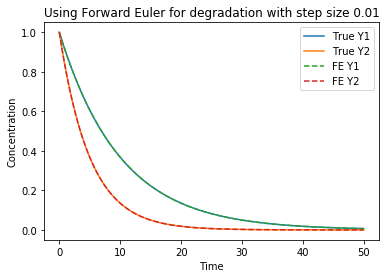

In [9]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,0.01), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), method="LSODA", t_eval=np.arange(0,50,0.01), rtol=1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for degradation with step size 0.01")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [10]:
%%timeit
#degradation with expicit trapezoidal

(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,0.01), np.array([1,1]), paramsDegrad)

67.2 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


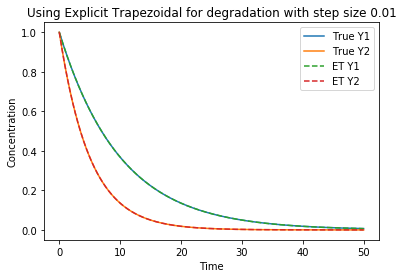

In [12]:
import scipy.integrate
import matplotlib.pyplot as plt
#comparing to scipy.integrate.solve_ivp
(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,0.01), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.01), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for degradation with step size 0.01")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

##   Forward Euler and Explicit Trapezoidal for Degradation at step size 0.01

So with the forward euler, the graph matches pretty well with the true and the FE lines. The step size is 0.01, and it takes around 32ms to run, which is relatively long for one function. I expect the explicit trapzoidal function to always run longer than the foward euler, because it also incorporates it. The fit being good means that 0.01 is a good step size, but because we want it to run faster, for example, we want to run something like this a lot, then we want a larger step size.

For the explicit trapezoidal function, 0.01 step size also allows for the graph to fit very well. It is hard to distinguish the lines from each other. The run time using explicit trapezoidal is just as I expected, being longer than forward euler with an execution time of around 65.7 ms. This is almost double the forward euler time.

In the next cells, I will be increasing the step size to 0.1, then 1, then 5.

In [13]:
%%timeit
#now we change the step size
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,0.1), np.array([1,1]), paramsDegrad)

3.2 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


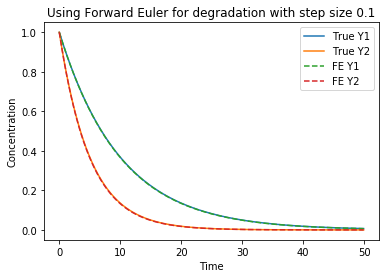

In [14]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,0.1), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for degradation with step size 0.1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [15]:
%%timeit
#degradation with expicit trapezoidal

(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,0.1), np.array([1,1]), paramsDegrad)

6.55 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


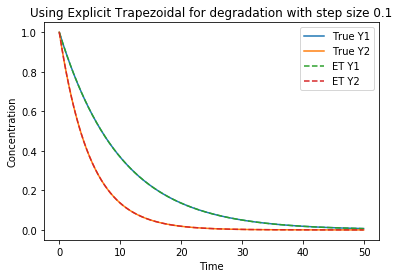

In [16]:
import scipy.integrate
import matplotlib.pyplot as plt
#comparing to scipy.integrate.solve_ivp
(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,0.1), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for degradation with step size 0.1")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

In [17]:
%%timeit
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,1), np.array([1,1]), paramsDegrad)

329 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


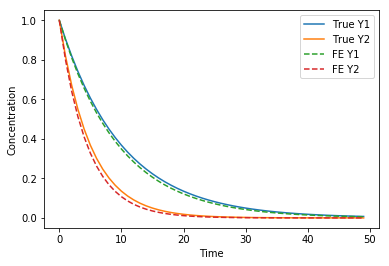

In [18]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,1), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [19]:
%%timeit

(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,1), np.array([1,1]), paramsDegrad)

675 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


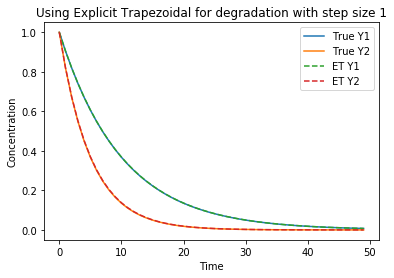

In [20]:
import scipy.integrate
import matplotlib.pyplot as plt
#comparing to scipy.integrate.solve_ivp
(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,1), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for degradation with step size 1")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

In [21]:
%%timeit
#now we change the step size one last time
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,5), np.array([1,1]), paramsDegrad)

63.2 µs ± 1.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


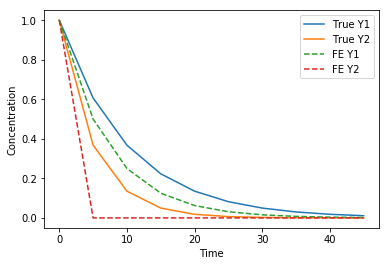

In [22]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(degradation_model, np.arange(0,50,5), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,5), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [23]:
%%timeit

(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,5), np.array([1,1]), paramsDegrad)

128 µs ± 3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


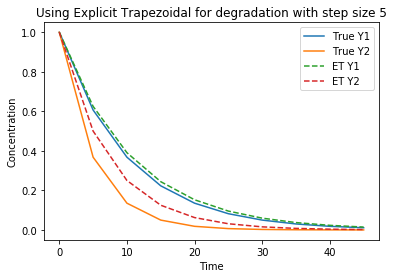

In [24]:
import scipy.integrate
import matplotlib.pyplot as plt
#comparing to scipy.integrate.solve_ivp
(t1,y1) = explicit_trapezoidal(degradation_model, np.arange(0,50,5), np.array([1,1]), paramsDegrad)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,5), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for degradation with step size 5")
plt.legend(["True Y1", "True Y2", "ET Y1", "ET Y2"]);

## Forward Euler and Explicit Trapezoidal on the degradation model using step sizes 0.1, 1, and 5

When we move on to step size 0.1, the forward euler function takes 2.87 ms to execute, which is faster than the 0.01, because it has less to look at. The explicit trapezoidal function takes 6.34 ms, which is also around double the forward euler, as expected. When looking at the graphs, however, the lines still seem very similar and indistinguishable for both forward euler and explicit trapzoidal by eye. When we look at errors, maybe we can see some sort of difference between 0.01 and 0.1 step sizes.

Looking at step size 1, we really see a difference in the graph on forward euler. We can see the explicit trapezoidal is still hard to distinguish. That means that explicit trapezoidal is better at approximating the true soluation at this point. As for the efficiency, the forward euler function takes 317 µs, which is an order of magnitude smaller than ms. Then the explicit trapezoidal function takes 634 µs, which is still around double, but faster than the previous time step's explicit trapezoidal runtime.

Lastly we look at a step size of 5, which I expect to completely be off in both functions. For forward euler, it takes around 61.5 µs to run, beating out the step size of 1 by a lot, and the explicit trapzoidal function takes 123 µs. As for the graph fitting, for forward euler, we can clearly see sharp edges where they completely skip the true curve, and it also happens in the explicit trapezoidal graph, just not as much as the forward euler one. The explicit trapezoidal graph is still roughly the same, and as we notice here just based on how the functions work, the forward euler one underestimates the true value, and the explicit trapezoidal overestimates it.

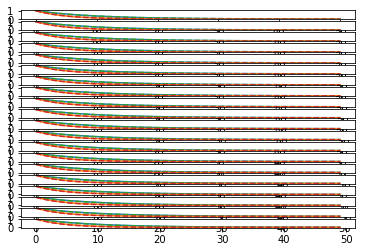

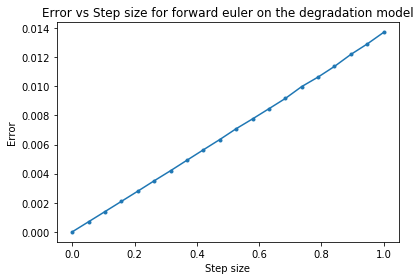

In [25]:
#plot errors for foward Euler and degradation
dts = np.linspace(1e-4,1,20)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    t = np.arange(0,50,dts[i])
    (t1,y1) = forwardEuler( degradation_model, t, y0, paramsDegrad)
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(0,50), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsDegrad] )
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t1, sol.y.T )
    plt.plot( t1, y1.T, '--')
    err[i] = np.mean(scipy.linalg.norm( sol.y-y1, np.inf, axis=0) )
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
plt.title("Error vs Step size for forward euler on the degradation model")
plt.ylabel("Error")
plt.xlabel("Step size")
plt.tight_layout()

## Error graph for forward euler on the degradation model

For forward euler on the degradation model, the error as we go slowly from step size 0 to 1 increases pretty linearly, but when we get to 1, the error is still really small, like 0.014, and in the graph we saw earlier, at 1 we can visibly see the difference. I think this is because the overall error gets amplified as we move towards the middle, then as we reach the end it gets smaller, making the average relatively small.

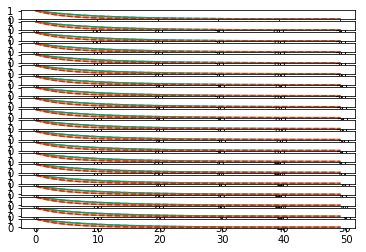

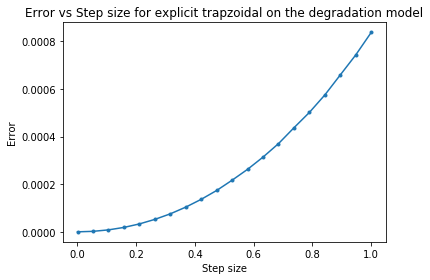

In [26]:
#explicit trapzoidal error for degradation
dts = np.linspace(1e-4,1,20)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    t = np.arange(0,50,dts[i])
    (t1,y1) = explicit_trapezoidal( degradation_model, t, y0, paramsDegrad)
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(0,50), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsDegrad] )
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t1, sol.y.T )
    plt.plot( t1, y1.T, '--')
    err[i] = np.mean(scipy.linalg.norm( sol.y-y1, np.inf, axis=0) )
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
plt.title("Error vs Step size for explicit trapzoidal on the degradation model")
plt.ylabel("Error")
plt.xlabel("Step size")
plt.tight_layout()

## Error graph for explicit trapezoidal for the degradation model

For explicit trapezoidal on the degradation model, the error as we slowly go from step size 0 to 1 is much smaller than forward euler. In a previous explanation, when we look at 0.1, for forward euler we can see in this graph that at the error is around 0.001, and for explicit trapezoidal, 0.1 step size is 0.0001 error, which is so much smaller than the forward euler error. The error graph is also exponential, but even though it grows at a faster rate than forward euler, the errors are so much smaller that it doesn't matter and is still a better estimate.

# Extension: Video frames for explicit trapezoidal method on the degradation model

## By changing the step size, to see how different each graph is based on the step size

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from IPython.display import HTML

fig = plt.figure()
ax = plt.axes(xlim=(0, 200), ylim=(0, 20))
line1, = ax.plot([], [], color = "r")
line2, = ax.plot([], [], color = "g")

def init(): #initiates my lines to nothing so i have some sort of placeholder
    line1.set_data([],[])
    line2.set_data([],[])
    return line1,

def animate(i):
    stepsize = float(i)*0.05
    print(stepsize)
    time = np.arange(0,50, stepsize)

    (t,y) = explicit_trapezoidal(degradation_model, 1, np.array([1,1]), paramsDegrad)
    
    line1.set_data(t, y[:,0])
    line2.set_data(t, y[:,1])
     
    return line1,

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=20, interval=50, blit=True)
plt.ylabel("Concentration");
plt.xlabel("Time");
plt.title("Varying Step Size for Degradation Model using Explicit Trapezoidal method")

red_patch = mpatches.Patch(color='Red', label='Y')
green_patch = mpatches.Patch(color='Green', label='Z')
plt.legend(handles=[red_patch,green_patch ])

plt.close(anim._fig)
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

# Predator Prey Model with Forward Euler and Explicit Trapezoidal

In [27]:
%%timeit
#this cell will look at time and run the forward euler on degradation
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,0.01), np.array([1,1]), paramsPP)

35.5 ms ± 972 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


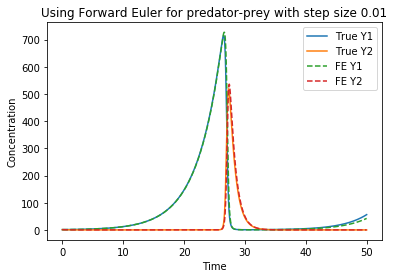

In [28]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,0.01), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.01), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for predator-prey with step size 0.01")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [29]:
%%timeit
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,0.01), np.array([1,1]), paramsPP)

78.4 ms ± 5.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


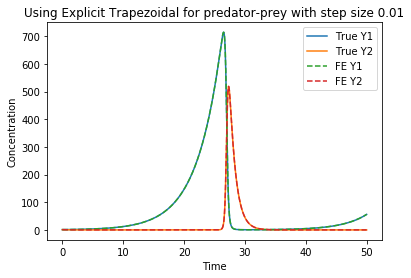

In [30]:
import scipy.integrate
import matplotlib.pyplot as plt
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,0.01), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.01), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for predator-prey with step size 0.01")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [31]:
%%timeit
#this cell will look at time and run the forward euler on degradation
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,0.1), np.array([1,1]), paramsPP)

3.7 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


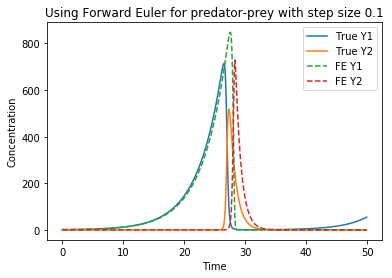

In [32]:
import scipy.integrate
import matplotlib.pyplot as plt
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,0.1), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for predator-prey with step size 0.1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [33]:
%%timeit
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,0.1), np.array([1,1]), paramsPP)

8.67 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


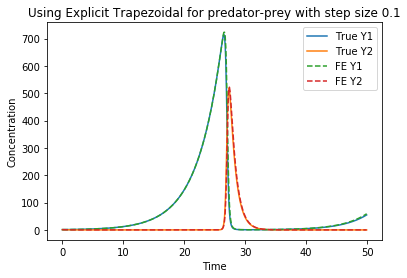

In [34]:
import scipy.integrate
import matplotlib.pyplot as plt
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,0.1), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,0.1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
#print(y1.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for predator-prey with step size 0.1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [35]:
%%timeit
#this cell will look at time and run the forward euler on degradation
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,1), np.array([1,1]), paramsPP)

376 µs ± 8.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


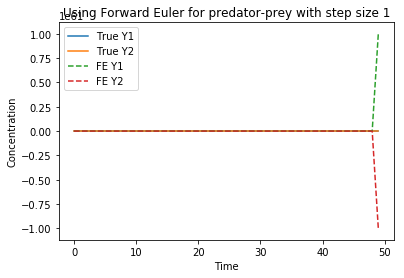

In [36]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1) = forwardEuler(predator_prey_model, np.arange(0,50,1), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
#print(y1.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Forward Euler for predator-prey with step size 1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

In [37]:
%%timeit
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,1), np.array([1,1]), paramsPP)

773 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


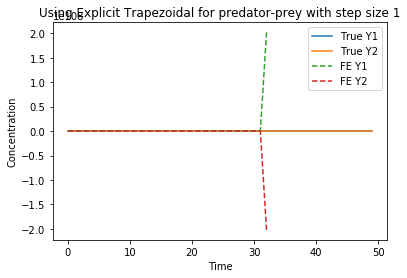

In [38]:
import scipy.integrate
import matplotlib.pyplot as plt
(t1,y1) = explicit_trapezoidal(predator_prey_model, np.arange(0,50,1), np.array([1,1]), paramsPP)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,50), y0=np.array([1,1]), t_eval=np.arange(0,50,1), method="LSODA", rtol= 1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
#print(y1.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Explicit Trapezoidal for predator-prey with step size 1")
plt.legend(["True Y1", "True Y2", "FE Y1", "FE Y2"]);

## Forward Euler and Explicit Trapezoidal on the predator-prey model using step sizes 0.01, 0.1, and 1

with a step size of 0.01 for the predator-prey model, forward euler takes around 34.3 ms. The explicit trapezoidal method should take longer, because of the nature of the function using forward euler in it, so that is what we will expect. With forward euler at 0.01 step size, the graph fits really well. I can kind of see the dotted line already a little off of the true line, but at least it keeps the curviture of the whole thing and recognizes the correct bumps.
For explicit trapezoidal at 0.01 step size, the dashed line fits much better than the forward euler, as I can barely see the dashes. It fits the curve and recognizes all the blips in concentration. It also takes 71.6 ms to run, so is less efficient than forward euler.

Changing the time step to 0.1, forward euler pretty much breaks down. It takes 3.56 ms to run, which is better than before, but it doesnt recognize the spikes in concentration as well. I can clearly see both lines when we get to the spike.
For explicit trapezoidal, it takes 7.51 ms, and really captures the spikes still. It looks more like the error for forward euler for 0.01, but still follows the curviture of the line.

I can't imagine that the predator-prey model is easy to model with large time steps, so I will only use 1. Because we need such small time steps, its fair to say that these methods of estimation are hard to measure spikes in the concentration. Using 1 as a step size, forward euler takes 377 µs, but completely breaks. When I print out the y from the forward euler output, the function stays very small then spikes to an absurd number. Explicit trapezoidal also does the same thing, as it uses forward euler for its first part, but then cannot correct it in its second. Explicit trapezoidal takes 900 µs. Even though they take such a short time to run, we need to use smaller time steps to get any results that make sense.

Works at: 0.2425
Breaks at: 0.2526


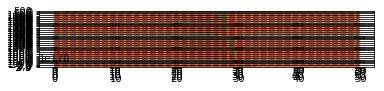

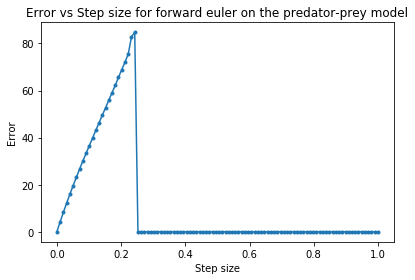

In [39]:
#plot errors for forwardEuler on the predator prey model

## weird behavior
dts = np.linspace(1e-4,1,100)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    try:
        t = np.arange(0,50,dts[i])
        (t1,y1) = forwardEuler( predator_prey_model, t, y0, paramsPP)
        sol = scipy.integrate.solve_ivp(fun=predator_prey_model, t_span=(0,50), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsPP] )
        plt.subplot( dts.size, 1, i+1 )
        plt.plot( t1, sol.y.T )
        plt.plot( t1, y1.T, '--')
        #print(y1.T)
        err[i] = np.mean(scipy.linalg.norm( sol.y-y1, np.inf, axis=0) )
    except:
        print("Works at:", dts[i-1])
        print("Breaks at:", dts[i])
        break
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
# plt.subplot(2,1,2)
# plt.plot( dts, err2, '.-' )
plt.title("Error vs Step size for forward euler on the predator-prey model")
plt.ylabel("Error")
plt.xlabel("Step size")
plt.tight_layout()

## Error graph for forward euler on the predator-prey model

For the error as we go up on forward euler for the predator-prey model, I noticed that the graph would break before it reached 1 in the testing phase, so in error, I used a try/except to catch around when it breaks. The graph seems to go up linearly with relatively large error until we reach between 0.2425 and 0.2526 for step sizes. Here the error fizzes and goes to 0 because I broke out of the function and we initiated the data with np.zeros. We can see where the function breaks, and that forward euler only works at extremely small step sizes.

Works at: 0.38389999999999996
Breaks at: 0.39399999999999996


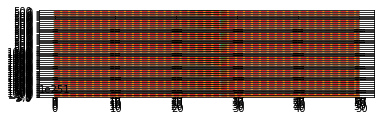

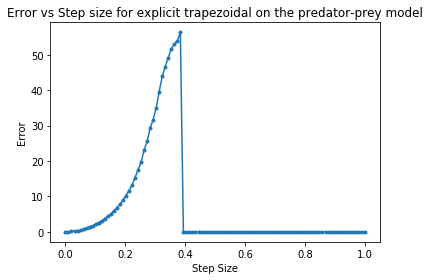

In [40]:
#plot errors for explicit trapzoidal on the predator prey model

## weird behavior
dts = np.linspace(1e-4,1,100)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    try:
        t = np.arange(0,50,dts[i])
        (t1,y1) = explicit_trapezoidal( predator_prey_model, t, y0, paramsPP)
        sol = scipy.integrate.solve_ivp(fun=predator_prey_model, t_span=(0,50), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsPP] )
        plt.subplot( dts.size, 1, i+1 )
        plt.plot( t1, sol.y.T )
        plt.plot( t1, y1.T, '--')
        #print(y1.T)
        err[i] = np.mean(scipy.linalg.norm( sol.y-y1, np.inf, axis=0) )
    except:
        print("Works at:", dts[i-1])
        print("Breaks at:", dts[i])
        break
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
# plt.subplot(2,1,2)
# plt.plot( dts, err2, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.title("Error vs Step size for explicit trapezoidal on the predator-prey model")
plt.tight_layout()

## Error graph for explicit trapezoidal on the predator-prey model

For the error as we go up on the explicit trapezoidal method on the predator-prey model, the graph also breaks, but a little later, at between 0.3839 and 0.3939 for the step sizes. The error is exponential as well, and doesn't go as high as forward euler when it breaks, but it still doesn't estimate it well unless the step size is under 0.2. Forward euler has such a high error at 0.2 compared to forward euler, so explicit trapezoidal is just better in the situation where there are spikes in the concentration.

# Forward Euler Adaptive Step Size method on the Degradation Model

In [41]:
%%timeit
(t1,y1, steps) = forwardEulerAdaptiveStepSize(degradation_model, 0, 50, np.array([1,1]), paramsDegrad, 1e-4)

4.23 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


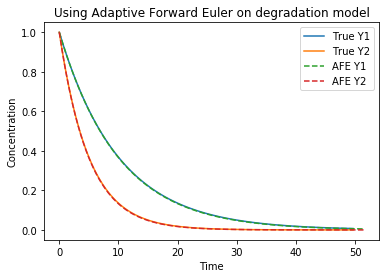

In [42]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the forward euler on degradation
#comparing to scipy.integrate.solve_ivp
(t1,y1, steps) = forwardEulerAdaptiveStepSize(degradation_model, 0, 50, np.array([1,1]), paramsDegrad, 1e-4)
dm = lambda t,y: degradation_model(t, y, paramsDegrad)
sol = scipy.integrate.solve_ivp(fun=dm,t_span=(0,60), y0=np.array([1,1]), t_eval=t, method="LSODA", rtol= 1e-8, atol=1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Adaptive Forward Euler on degradation model")
plt.legend(["True Y1", "True Y2", "AFE Y1", "AFE Y2"]);

Forward adaptive euler really makes the graph fit, and we dont have to think about the step size because the function takes care of that. The efficiency is at 4.15 ms, which is very fast for how accurate it is. This is the best function by far because it takes as little time steps as possible to get as little error as possible. For the degradation model, it is much easier to fit, so lets go look at the predator-prey model after looking at the error.

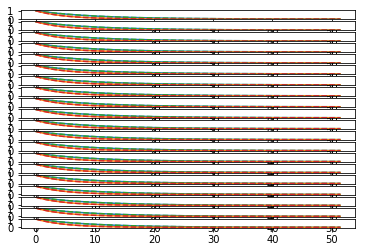

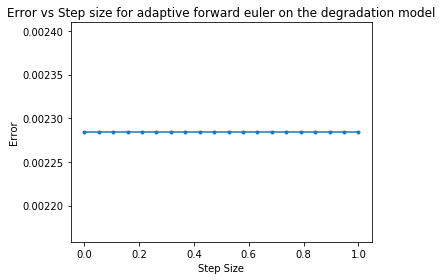

In [43]:
dts = np.linspace(1e-4,1,20)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    #t = np.arange(0,50,dts[i])
    (t,y, steps) = forwardEulerAdaptiveStepSize( degradation_model, 0, 50, y0, paramsDegrad, 1e-4)
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(0,60), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsDegrad] )
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t, sol.y.T )
    plt.plot( t, y.T, '--')
    err[i] = np.mean(scipy.linalg.norm( sol.y-y, np.inf, axis=0) )
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.title("Error vs Step size for adaptive forward euler on the degradation model")
plt.tight_layout()

The error stays very small, between 0.00225 and 0.0023, and stays constant. This means that the accuracy is very good for the step sizes it uses throughout the adaptive method, which was how it was designed.

# Forward Euler Adaptive Step Size method on the Predator-Prey Model

In [44]:
%%timeit
(t1,y1, steps) = forwardEulerAdaptiveStepSize(predator_prey_model, 0, 50, np.array([1,1]), paramsPP, 1e-4)

354 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


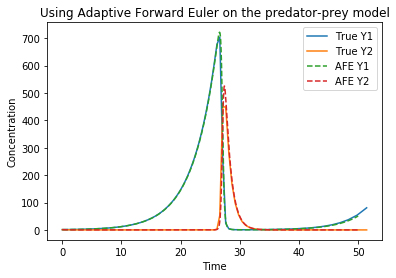

In [45]:
import scipy.integrate
import matplotlib.pyplot as plt
#plot the adaptive on predator-prey
#comparing to scipy.integrate.solve_ivp
(t1,y1, steps) = forwardEulerAdaptiveStepSize(predator_prey_model, 0, 50, np.array([1,1]), paramsPP, 1e-4)
pp = lambda t,y: predator_prey_model(t, y, paramsPP)
sol = scipy.integrate.solve_ivp(fun=pp,t_span=(0,60), y0=np.array([1,1]), t_eval=t, method="LSODA", rtol= 1e-8, atol=1e-8)
plt.gca().set_prop_cycle(None)
plt.plot(sol.t, sol.y.T)
plt.plot(t1, y1.T, "--")
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Using Adaptive Forward Euler on the predator-prey model")
plt.legend(["True Y1", "True Y2", "AFE Y1", "AFE Y2"]);

The adaptive method on the predator prey model runs in 355 ms, which is relatively long, because it needs very small step sizes in order to run accurately. As we saw with the 0.1 step size on forward euler, we actually need something smaller than that. So when we run it, of course it is going to fit the curve very well. Let's move on to the error.

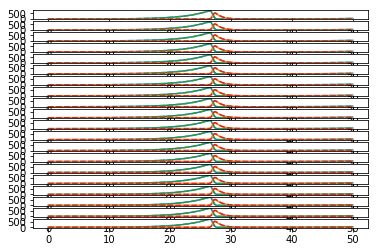

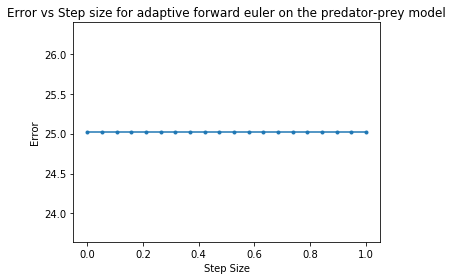

In [11]:
#plot errors
dts = np.linspace(1e-4,1,20)
err = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    #t = np.arange(0,50,dts[i])
    (t,y, steps) = forwardEulerAdaptiveStepSize( predator_prey_model, 0, 50, y0, paramsPP, 1e-4)
    sol = scipy.integrate.solve_ivp(fun=predator_prey_model, t_span=(0,60), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsPP] )
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t, sol.y.T )
    plt.plot( t, y.T, '--')
    err[i] = np.mean(scipy.linalg.norm( sol.y-y, np.inf, axis=0) )
    
plt.figure()
# plt.subplot(2,1,1)
plt.plot( dts, err, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.title("Error vs Step size for adaptive forward euler on the predator-prey model")
plt.tight_layout()

The error is a lot better, as it is very constant for the predator-prey model. The previous ones broke as we went up in step size, so this model knows where to use 1.0 step size, and when to get smaller so that it actually becomes accurate. This constant small error is what makes the estimation fit the true value so much better.

# Extension: Van Der Pol oscillator

In [46]:
# function the odes for van der pol oscillator
def vanDerPol_model(t, y, params):
    y1 = y[0]
    y2 = y[1]
    u = params[0]
    dydt = np.zeros((2,))
    dydt[0] = y2
    dydt[1] = (u * (1 - (y1**2)) * y2 ) - y1
    return dydt

Because until now, we only really have coded explicit differential equation solvers, I will be using a scipy.integrate Runge-Kutta method called Radau. On the scipy.integrate portion of the scipy site, it shows to be an implicit method. I will be comparing it against the adaptive step size forward euler that we made in this project. To find error, I will be comparing them to LSODA, which we used as the true solution for this project.

In [85]:
paramsVM = [50]
vm = lambda t,y: vanDerPol_model(t, y, paramsVM)
sol1LSODA = scipy.integrate.solve_ivp(fun=vm, t_span = (0,400), y0 = np.array([1,1]), method = "LSODA", t_eval = np.arange(0,400,0.1))
sol1Radau = scipy.integrate.solve_ivp(fun=vm, t_span = (0,400), y0 = np.array([1,1]), method = "Radau", t_eval = np.arange(0,400,0.1))
(t1,y1, steps) = forwardEulerAdaptiveStepSize(vanDerPol_model, 0, 400, np.array([1,1]), paramsVM, 1e-4)

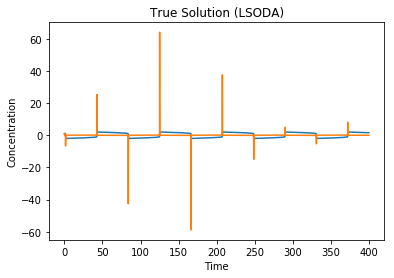

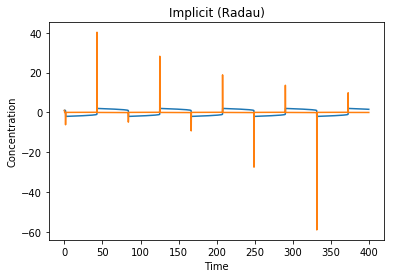

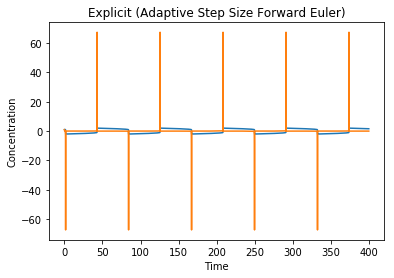

In [86]:
#plot
plt.plot(sol1LSODA.t, sol1LSODA.y.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("True Solution (LSODA)")
plt.figure()
plt.plot(sol1Radau.t, sol1Radau.y.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Implicit (Radau)")
plt.figure()
plt.plot(t1, y1.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Explicit (Adaptive Step Size Forward Euler)");

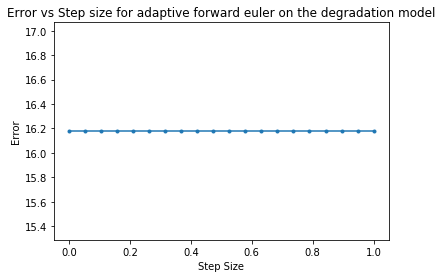

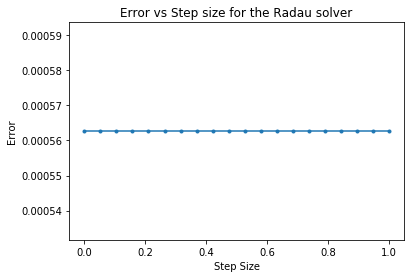

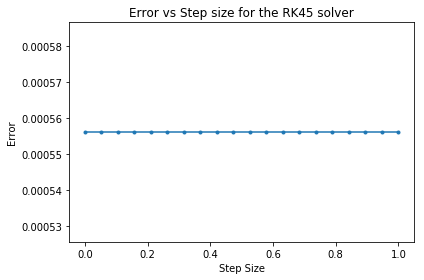

In [94]:
#calculate errors
dts = np.linspace(1e-4,1,20)
err1 = np.zeros( (dts.size,) )
err2 = np.zeros( (dts.size,) )
err3 = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    #t = np.arange(0,200,dts[i])
    (t,y, steps) = forwardEulerAdaptiveStepSize( vanDerPol_model, 0, 200, y0, paramsVM, 1e-4)
    sol = scipy.integrate.solve_ivp(fun=vanDerPol_model, t_span=(0,220), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsVM] )
    solRadau = scipy.integrate.solve_ivp(fun=vanDerPol_model, t_span=(0,220), y0=y0, method='Radau', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsVM] )
    solRK45 = scipy.integrate.solve_ivp(fun=vanDerPol_model, t_span=(0,220), y0=y0, method='RK45', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsVM] )
    # plt.subplot( dts.size, 1, i+1 )
    # plt.plot( t, sol.y.T )
    # plt.plot( t, y.T, '--')
    err1[i] = np.mean(scipy.linalg.norm( sol.y-y, np.inf, axis=0) )
    err2[i] = np.mean(scipy.linalg.norm( sol.y-solRadau.y, np.inf, axis=0) )
    err3[i] = np.mean(scipy.linalg.norm( sol.y-solRK45.y, np.inf, axis=0) )
    
plt.figure()
plt.plot( dts, err1, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.title("Error vs Step size for adaptive forward euler on the degradation model")

plt.figure()
plt.plot( dts, err2, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.title("Error vs Step size for the Radau solver")

plt.figure()
plt.plot( dts, err3, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.title("Error vs Step size for the RK45 solver")
plt.tight_layout()

The radau solver is a much better solver than the adaptive step size forward euler method, clearly seen from the errors, and RK45 is also close to 0 as an error compared to LSODA. When we are at u=50, the implicit method is nececssary, as the error is very different.

In [95]:
paramsVM = [1]
vm = lambda t,y: vanDerPol_model(t, y, paramsVM)
sol1LSODA = scipy.integrate.solve_ivp(fun=vm, t_span = (0,400), y0 = np.array([1,1]), method = "LSODA", t_eval = np.arange(0,400,0.1))
sol1Radau = scipy.integrate.solve_ivp(fun=vm, t_span = (0,400), y0 = np.array([1,1]), method = "Radau", t_eval = np.arange(0,400,0.1))
(t1,y1, steps) = forwardEulerAdaptiveStepSize(vanDerPol_model, 0, 400, np.array([1,1]), paramsVM, 1e-4)

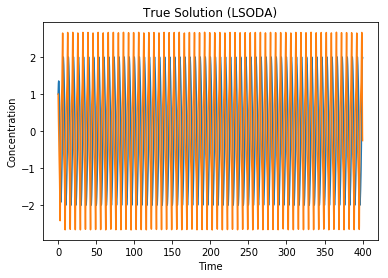

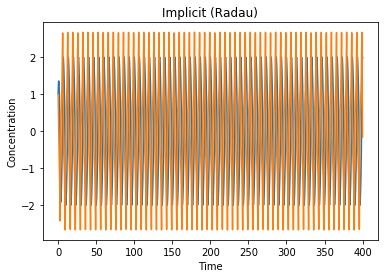

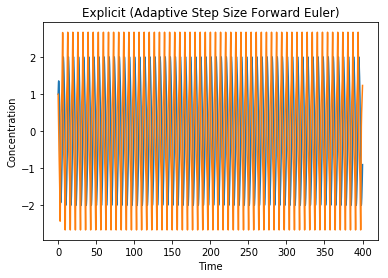

In [96]:
#plot
plt.plot(sol1LSODA.t, sol1LSODA.y.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("True Solution (LSODA)")
plt.figure()
plt.plot(sol1Radau.t, sol1Radau.y.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Implicit (Radau)")
plt.figure()
plt.plot(t1, y1.T)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title("Explicit (Adaptive Step Size Forward Euler)");

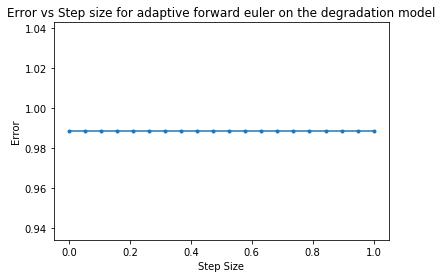

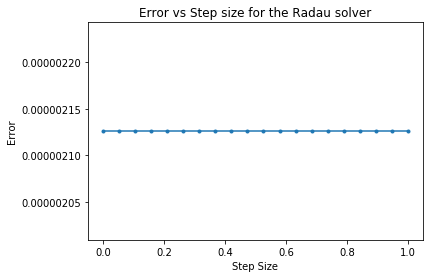

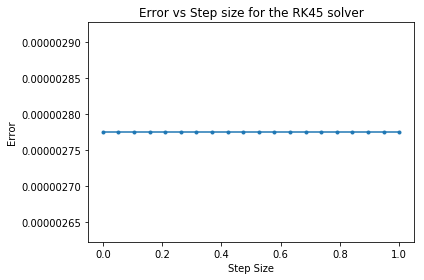

In [97]:
#calculate errors
dts = np.linspace(1e-4,1,20)
err1 = np.zeros( (dts.size,) )
err2 = np.zeros( (dts.size,) )
err3 = np.zeros( (dts.size,) )
y0 = np.array([1,1])

for i in range(dts.size):
    #t = np.arange(0,200,dts[i])
    (t,y, steps) = forwardEulerAdaptiveStepSize( vanDerPol_model, 0, 200, y0, paramsVM, 1e-4)
    sol = scipy.integrate.solve_ivp(fun=vanDerPol_model, t_span=(0,220), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsVM] )
    solRadau = scipy.integrate.solve_ivp(fun=vanDerPol_model, t_span=(0,220), y0=y0, method='Radau', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsVM] )
    solRK45 = scipy.integrate.solve_ivp(fun=vanDerPol_model, t_span=(0,220), y0=y0, method='RK45', rtol=1e-8, atol=1e-8, t_eval=t, args=[paramsVM] )
    # plt.subplot( dts.size, 1, i+1 )
    # plt.plot( t, sol.y.T )
    # plt.plot( t, y.T, '--')
    err1[i] = np.mean(scipy.linalg.norm( sol.y-y, np.inf, axis=0) )
    err2[i] = np.mean(scipy.linalg.norm( sol.y-solRadau.y, np.inf, axis=0) )
    err3[i] = np.mean(scipy.linalg.norm( sol.y-solRK45.y, np.inf, axis=0) )
    
plt.figure()
plt.plot( dts, err1, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.title("Error vs Step size for adaptive forward euler on the degradation model")

plt.figure()
plt.plot( dts, err2, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.title("Error vs Step size for the Radau solver")

plt.figure()
plt.plot( dts, err3, '.-' )
plt.ylabel("Error")
plt.xlabel("Step Size")
plt.title("Error vs Step size for the RK45 solver")
plt.tight_layout()

With the errors, and using u = 1 here instead of 50, there are more frequent oscillations, meaning that it is easier to catch the oscillation with the explicit method. The explicit method then is able to be used, because it is under 1, instead of something like 16, making it ok to use for estimation.

<hr style="border:2px solid gray"> </hr>

Acknowledgements

*Replace this text with links to external resources and thanks to people you worked with.*